# NTSB Feature Selection

This notebook examines the rates of missingness for each value in the master NTSB dataset, as well as population for dummy variables, allowing us to pare down features which may not be likely to be useful/predictive.

### Note: 
This notebook employs the **'missingno'** package, which can be installed with a "pip install missingno" command in your Terminal.
***


In [23]:
import pandas as pd
import missingno as mno

In [24]:
data = pd.read_csv("../data/ntsb/cleaned/master_train.csv")

In [25]:
missing = pd.DataFrame(data.isna().sum())
missing_pct = missing / len(data)

In [26]:
# mno.bar(data,sort='ascending')

### Drop columns we don't need

In [27]:
# Drop columns that we've already processed and no longer need
data.drop(columns=['Aircraft_ID', 'ev_id', 'finding_description'], inplace=True)

In [28]:
def drop_sparse_columns(data, threshold, safe_cols=None):
    '''
    Drops columns from data that do not contain at least a given proportion of non-empty entries
    
    Inputs
        data: pandas DataFrame
        threshold: float in [0,1], all columns with less than this proportion of non-empty entries are dropped
        safe_cols: list of names of columns that should not be dropped even if they are below the sparsity threshold
    Outputs
        data: same DataFrame with appropriate columns dropped
    '''
    # list of columns to drop if they are too sparse
    unsafe_cols = [col for col in data.columns if col not in safe_cols]

    for col in unsafe_cols:
        # calculate proportion of na entries in col
        prop_na = data[col].isna().sum() / len(data)
        
        # drop col if the column is too sparse
        if prop_na > 1 - threshold:
            data.drop(columns=col, inplace=True)
    
    return data

In [ ]:
# If we want to impute 0 for the unknown inj_*_grnd columns then we don't need to mark them safe
data = drop_sparse_columns(data, 0.8, safe_cols=['total_seats', 'damage', 'acft_category', 'acft_make'])

### Get dummy variables for non-sparse values in categorical columns

In [30]:
def get_dummies_frequent_values(data, threshold, columns=None):
    '''
    Get dummy variables for a column, but only for values whose frequency is at least given proportion
    All other values have no dummy variable. Note that NA values are treated the same as infrequent values

    Note: we require the columns argument so that we don't consider non-dummy columns in the loop below
    
    Inputs
        data: pandas DataFrame
        columns: list of column names to turn into dummies
        threshold: float in [0,1], dummy column only created for value whose frequency is at least this proportion
    Outputs
        one_hot_data: pandas DataFrame of required dummy variables
    '''

    orig_cols = data.columns

    data = pd.get_dummies(data, columns=columns, dtype=int)

    # Use set difference to get list of new dummy columns
    new_cols = list(set(data.columns) - set(orig_cols))

    # drop sparse columns
    for col in new_cols:
        # frequency of value corresponding to this column
        freq = sum(data[col]) / len(data)

        if freq < threshold:
            data.drop(columns=col, inplace=True)

    # TODO drop columns as needed to avoid multicollinearity (if necessary, although I assume it will be)

    return data

In [31]:
# threshold set to 0.04 to get dummies for DAYL and NITE only
# TODO will this work on the test / validation data if the proportions of each light_cond are a bit different?

data = get_dummies_frequent_values(data, 0.03, ['light_cond'])

In [32]:
data['num_people_onboard'] = data['inj_tot_f'] + data['inj_tot_m'] + data['inj_tot_n'] + data['inj_tot_s']
data['prop_onboard_inj'] =  (data['num_people_onboard'] - data['inj_tot_n'])/ data['num_people_onboard']
data['prop_onboard_inj_m'] =  data['inj_tot_m'] / data['num_people_onboard']
data['prop_onboard_inj_s'] =  data['inj_tot_s'] / data['num_people_onboard']
data['prop_onboard_inj_f'] =  data['inj_tot_f'] / data['num_people_onboard']

In [38]:
import matplotlib.pyplot as plt
import numpy as np

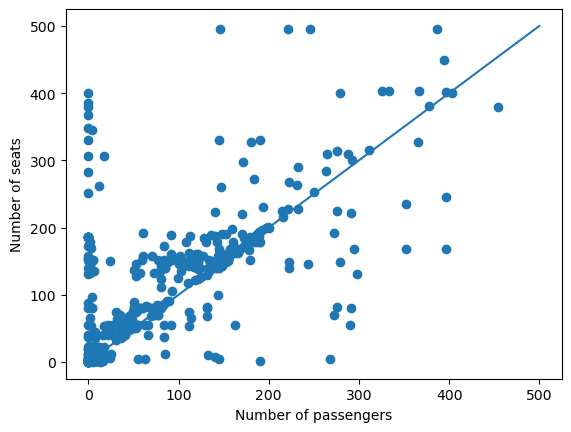

In [41]:
real_data = data.loc[data['total_seats']<500]

x = np.linspace(0,500,1000)

plt.scatter(real_data['num_people_onboard'], real_data['total_seats'])
plt.xlabel('Number of passengers')
plt.ylabel('Number of seats')
plt.plot(x,x)
plt.show()

In [50]:
ppl_count_cols = ['inj_tot_m', 'inj_tot_s', 'inj_tot_f', 'inj_tot_n', 
                  'inj_m_grnd', 'inj_f_grnd', 'inj_s_grnd',
                  'num_people_onboard', 'total_seats']

weird_data = data.loc[data['num_people_onboard'] > data['total_seats']]

weird_data[ppl_count_cols]

,inj_tot_m,inj_tot_s,inj_tot_f,inj_tot_n,inj_m_grnd,inj_f_grnd,inj_s_grnd,num_people_onboard,total_seats
14,3,2,0,0,NaN,NaN,NaN,5,4.0
46,1,0,0,4,NaN,NaN,NaN,5,1.0
47,0,3,9,0,0.0,NaN,NaN,12,10.0
52,0,0,0,9,NaN,NaN,NaN,9,8.0
104,0,0,0,5,NaN,NaN,NaN,5,4.0
...,...,...,...,...,...,...,...,...,...
16238,0,0,0,4,NaN,NaN,NaN,4,3.0
16252,3,2,0,0,NaN,0.0,NaN,5,4.0
16312,0,0,0,6,NaN,NaN,NaN,6,2.0
16423,0,0,0,3,NaN,NaN,NaN,3,2.0
